In [1]:
from models.dataset import Dataset, DatasetReality
from models.pipeline import prep_data
from ana.visual import STAT, ROC, FEAT

import numpy as np
import random
np.random.seed(7)
random.seed(7)

import warnings
from sklearn.linear_model import LogisticRegression
warnings.simplefilter('ignore')

In [2]:
# dataset, X, y, pairs, index = prep_data(Dataset, shuffle_interval=3)
dataset = prep_data(Dataset, test=0.1, shuffle=True, seed=None)

 - Initialize image encoder..
  - Set feature names..
  - Build category level idf..
  - Build similarity normalizer..
 - Initialize text encoder..
 - Initialize joint encoder..
 - Set feature names..
 - Preparing data..
    Fetched - [82]]
    Fetched - [10]
  - Data train shape (246, 11259)
  - Data test shape (30, 11259)


In [3]:
# higher class weight of 0 will always make it easier in term of precision
# because of imbalance
clf = LogisticRegression(# random_state=0,
                         solver='liblinear',
                         class_weight={1: 1, 0:0.1},
                         penalty='l1', #'l2' use l1 to learn sparsely
                         C=1.0,
                         max_iter=1000)

# interval = 3 #3 #4
# ind_test = int(X.shape[0]/interval * 0.9) * interval
# print('# train: ', ind_test)
# print('# test: ', X.shape[0] - ind_test)
# clf.fit(X[:ind_test], y[:ind_test])
# clf.fit(X, y)
# y_true = y[ind_test:]
# y_prob = clf.predict_proba(X[ind_test:])[:,1]
clf.fit(dataset.data_train[:,:-1], 
        dataset.data_train[:,-1].toarray().flatten())
y_true = dataset.data_test[:,-1].toarray().flatten()
y_prob = clf.predict_proba(dataset.data_test[:,:-1])[:,1]

10 positives out of 30 test examples
Overall accuracy: 0.633333
*Recall(thresh=0.5)/AccuracyOf1: 0.300000
Precision(thresh=0.5): 0.428571
AccuracyOf0(thresh=0.5): 0.633333


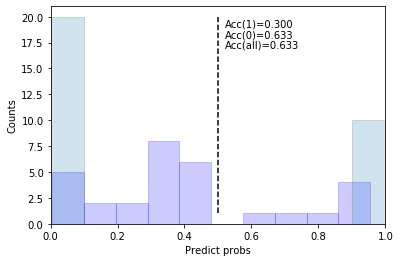

In [17]:
suffix = 'temp'
STAT(y_true, y_prob, path='STAT_%s' % suffix)

precision | recall | F1 | threshold
------------------------------
0.385 | 1.000 | 0.556 | 0.096
0.360 | 0.900 | 0.514 | 0.186
0.333 | 0.800 | 0.471 | 0.192
0.304 | 0.700 | 0.424 | 0.200
0.318 | 0.700 | 0.438 | 0.245
0.333 | 0.700 | 0.452 | 0.306
0.350 | 0.700 | 0.467 | 0.337
0.316 | 0.600 | 0.414 | 0.364
0.333 | 0.600 | 0.429 | 0.366
0.308 | 0.400 | 0.348 | 0.437
0.333 | 0.400 | 0.364 | 0.440
0.364 | 0.400 | 0.381 | 0.442
0.400 | 0.400 | 0.400 | 0.466
0.444 | 0.400 | 0.421 | 0.471
0.500 | 0.400 | 0.444 | 0.472
0.429 | 0.300 | 0.353 | 0.599
0.500 | 0.300 | 0.375 | 0.718
0.600 | 0.300 | 0.400 | 0.849
0.500 | 0.200 | 0.286 | 0.861
0.667 | 0.200 | 0.308 | 0.872
0.500 | 0.100 | 0.167 | 0.947
0.000 | 0.000 | nan | 0.955
------------------------------


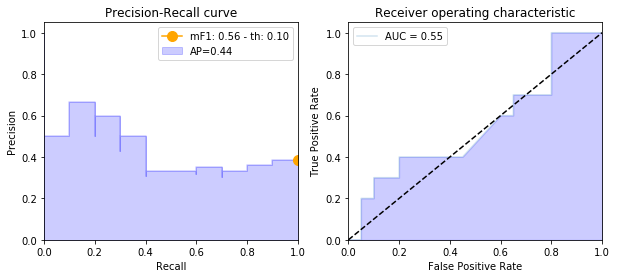

In [18]:
ROC(y_true, y_prob, path='ROC_%s' % suffix)

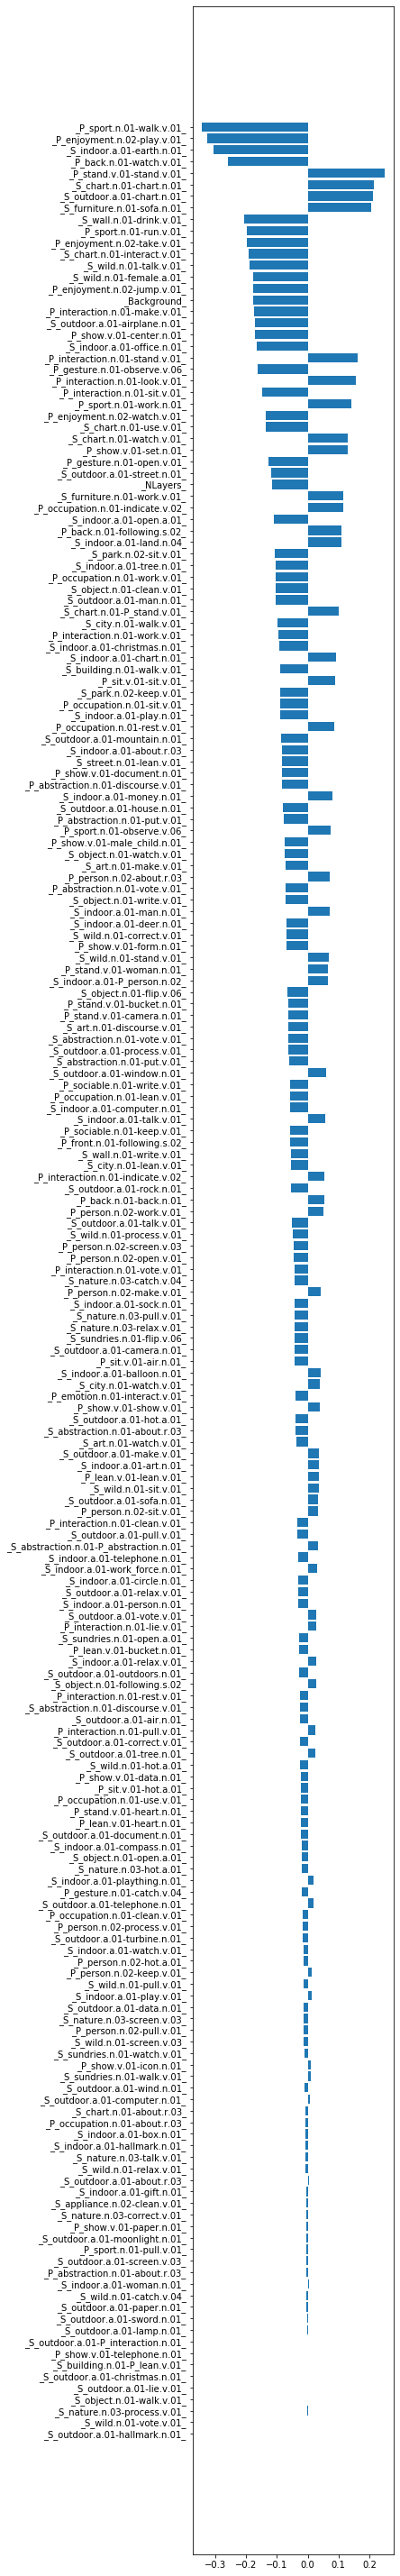

In [6]:
FEAT(dataset, clf, path='FEAT_%s' % suffix)

### error analysis

In [8]:
y_true.astype(int)

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0])

In [9]:
(y_prob > 0.687).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1])

In [10]:
y_prob

array([0.58481366, 0.57154211, 0.61854462, 0.61931428, 0.61931428,
       0.61931428, 0.58481366, 0.57154211, 0.58481366, 0.23886008,
       0.60562418, 0.26974359, 0.63946162, 0.65191065, 0.60562418,
       0.88489954, 0.63946162, 0.88489954, 0.82251494, 0.30538492,
       0.82203806, 0.9005642 , 0.60640332, 0.20853314, 0.68722989,
       0.63946162, 0.65619668, 0.70855047, 0.22910718, 0.70855047])

In [11]:
index[ind_test:]/3

array([72.        , 72.33333333, 72.66666667, 86.        , 86.33333333,
       86.66666667, 14.        , 14.33333333, 14.66666667, 57.        ,
       57.33333333, 57.66666667, 23.        , 23.33333333, 23.66666667,
       83.        , 83.33333333, 83.66666667, 67.        , 67.33333333,
       67.66666667, 25.        , 25.33333333, 25.66666667, 68.        ,
       68.33333333, 68.66666667, 47.        , 47.33333333, 47.66666667])

In [12]:
coeff_dict = dict(zip(dataset.features_, clf.coef_.tolist()[0]))

In [54]:
from scipy import sparse

ind = 3
print(dataset.txt_encoder.tokenizer(pairs[ind_test:][ind][1]))
print(dataset.img_encoder.layer2keyword(pairs[ind_test:][ind][0]))

vec = dataset.encode(*pairs[ind_test:][ind])
tuples = []
for i in np.where(vec!=0)[0]:
    feature = dataset.features_[i]
    tuples.append((feature, vec[i], coeff_dict[feature]))
for f, v, c in sorted(tuples, key=lambda x: abs(x[1]))[::-1]:
    print('%40s % 10.6f %.6f' % (f,v,c))

# bigram doesn't act in the similarity.
# thus bigrams are not visible here since we filter out zero features

['woman.n.01', 'keep.v.01', 'plaything.n.01']
['indoor.a.01', 'object.n.01', 'sundries.n.01', 'person.n.02', 'sit.v.01']
          _S_object.n.01-plaything.n.01_  10.491570 0.000000
                  _P_sit.v.01-keep.v.01_   9.868253 0.000000
        _S_sundries.n.01-plaything.n.01_   7.738709 0.000000
          _P_person.n.02-plaything.n.01_   6.692120 0.000000
                keep.v.01 plaything.n.01   4.839452 0.000000
             _P_sit.v.01-plaything.n.01_  -4.793330 0.000000
               _P_person.n.02-keep.v.01_  -4.793330 0.000000
             _S_sundries.n.01-keep.v.01_  -4.793330 0.000000
               _S_object.n.01-keep.v.01_  -4.793330 0.000000
          _S_indoor.a.01-plaything.n.01_  -4.793330 0.000000
               _S_indoor.a.01-keep.v.01_  -4.793330 0.000000
                    woman.n.01 keep.v.01   4.433987 0.000000
                          plaything.n.01   4.433987 0.000000
                               keep.v.01   4.433987 0.000000
                         

In [15]:
sigmoid(2.0*0.14+1.64*0.033)

0.5827614973270983

In [16]:
## 0
# only woman and n_layers carries non-zero value as a feature
# caused by insufficient data

In [21]:
print(dataset.joint_encoder.idf_['plaything.n.01'])
print(dataset.joint_encoder.simi_['_S_object.n.01-plaything.n.01_'])
print(dataset.joint_encoder.simi_normalizer.transform(dataset.joint_encoder.simi_['_S_object.n.01-plaything.n.01_']))
print(dataset.joint_encoder.simi_normalizer.mean)
print(dataset.joint_encoder.simi_normalizer.std)

4.433987204485146
2.2512917986064953
2.3661705326503535
0.7060029855494958
0.6530758420552714


In [22]:
## 1
# object and plaything are moderately similar
# plaything is very rare (only appear once/twice (didn't check))
# though this feature in this datus is large, it didn't take any effect

In [46]:
pairs[ind_test:]

[(['A2211', 'A3211'], 'A woman looks in the window.\n'),
 (['A2211', 'A3211'], 'A man is watching a movie.\n'),
 (['A1', 'A312'], 'A woman looks in the window.\n'),
 (['A1', 'A2114', 'A322'], 'A woman holds a toy.\n'),
 (['A1', 'A2114', 'A322'], 'A woman works in an office.\n'),
 (['A1', 'A2121', 'A3212'], 'A woman holds a toy.\n'),
 (['A1', 'A325'], 'A woman is showing love'),
 (['A1', 'A325'], 'A man drinks coffee at the airport window'),
 (['A2121', 'A3213'], 'A woman is showing love'),
 (['A1', 'A312'], 'A woman is standing to annotate.\n'),
 (['A1', 'A312'], 'A man is riding a bike on the street.\n'),
 (['A1', 'A2222', 'A324'], 'A woman is standing to annotate.\n'),
 (['A1', 'A2211', 'A315'], 'A man is riding a bike on the street.\n'),
 (['A1', 'A2211', 'A315'], 'A woman is playing with a bunch of balloons.\n'),
 (['A2122', 'A312'], 'A man is riding a bike on the street.\n'),
 (['A1', 'A2122', 'A312'], 'A woman sat to rest.\n'),
 (['A1', 'A2122', 'A312'], 'There are three trademar

In [21]:
dataset.getOneLayerSent(txt_name='text/72.txt',
                        img_name='images/72.svg')

(['A1', 'A2222', 'A325'], 'A man and a woman jump to celebrate.')

### reality discriminator

In [4]:
# dataset_r, X_r, y_r, pairs_r, index_r = prep_data(DatasetReality, shuffle_interval=2)
dataset_r = prep_data(DatasetReality,
                      index=(dataset.index_train, dataset.index_test))

 - Initialize image encoder..
  - Set feature names..
  - Build category level idf..
  - Build similarity normalizer..
 - Initialize text encoder..
 - Initialize joint encoder..
 - Set feature names..
 - Build fake layers..
 - Set feature names..
 - Preparing data..
    Fetched - [82]]
    Fetched - [10]
  - Data train shape (164, 311)
  - Data test shape (20, 311)


In [5]:
# higher class weight of 0 will always make it easier in term of precision
# because of imbalance
clf_r = LogisticRegression(# random_state=0,
                           solver='liblinear',
                           class_weight={1: 1, 0: 1},
                           penalty='l1', #'l2' use l1 to learn sparsely
                           C=1.0,
                           max_iter=1000)

clf_r.fit(dataset_r.data_train[:,:-1], 
          dataset_r.data_train[:,-1].toarray().flatten())
y_true = dataset_r.data_test[:,-1].toarray().flatten()
y_prob = clf_r.predict_proba(dataset_r.data_test[:,:-1])[:,1]

10 positives out of 20 test examples
Overall accuracy: 0.600000
*Recall(thresh=0.5)/AccuracyOf1: 0.500000
Precision(thresh=0.5): 0.625000
AccuracyOf0(thresh=0.5): 0.600000


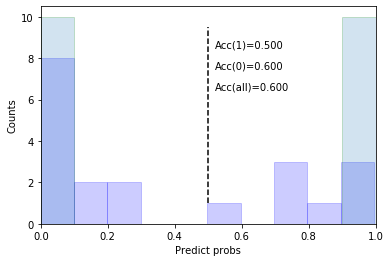

In [21]:
suffix = 'temp'
STAT(y_true, y_prob, path='realitySTAT_%s' % suffix)

precision | recall | F1 | threshold
------------------------------
0.625 | 1.000 | 0.769 | 0.006
0.600 | 0.900 | 0.720 | 0.008
0.643 | 0.900 | 0.750 | 0.030
0.692 | 0.900 | 0.783 | 0.031
0.667 | 0.800 | 0.727 | 0.130
0.727 | 0.800 | 0.762 | 0.151
0.700 | 0.700 | 0.700 | 0.258
0.667 | 0.600 | 0.632 | 0.270
0.625 | 0.500 | 0.556 | 0.563
0.714 | 0.500 | 0.588 | 0.697
0.833 | 0.500 | 0.625 | 0.738
0.800 | 0.400 | 0.533 | 0.776
1.000 | 0.400 | 0.571 | 0.864
1.000 | 0.300 | 0.462 | 0.928
1.000 | 0.200 | 0.333 | 0.965
1.000 | 0.100 | 0.182 | 0.995
------------------------------


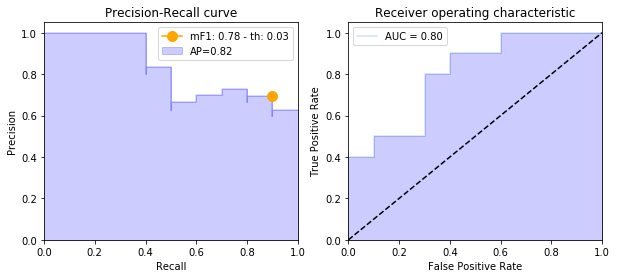

In [22]:
ROC(y_true, y_prob, path='realityROC_%s' % suffix)

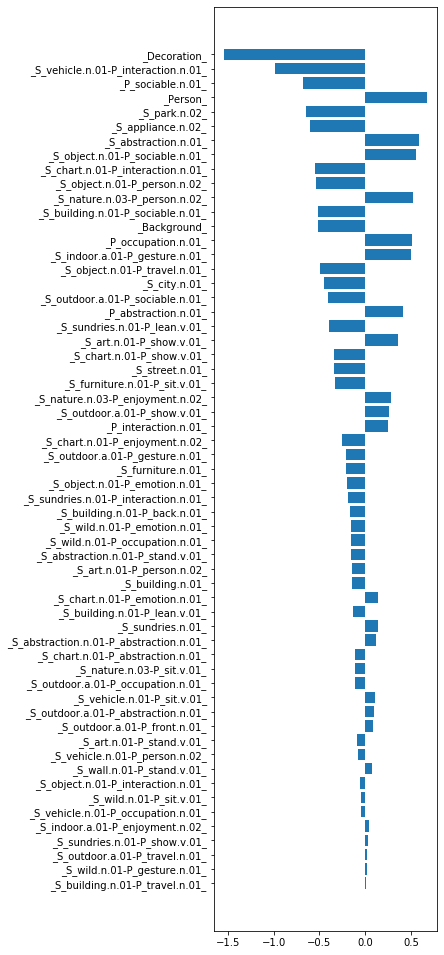

In [14]:
FEAT(dataset_r, clf_r, path='realityFEAT_%s' % suffix)

wild - gesture ++ (play in the park)

surrounding - object? --
person - interaction? --

if object stuff, interaction is rare?

In [12]:
# todo - unseen keywords

In [12]:
from models.model import Discriminator
import dill
discriminator = Discriminator(dataset, clf, dataset_r, clf_r)
with open('results/discriminator.pkl', 'wb') as f:
    dill.dump(discriminator, f)

In [1]:
from tools.text_process import LemmaTokenizer
from models.model import Discriminator
from models.model import categMetric
import numpy as np
import dill
import warnings
warnings.simplefilter('ignore')

discriminator = Discriminator.unpickle()
mF1s = []
lambs = np.arange(0,1.2,0.2)
for lamb in lambs:
    mF1s.append(categMetric(discriminator, lamb=lamb))

0-----------[667]
1-----------[667]


/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/image_process.py:61: RuntimeWarning: In image images/14.svg A2 is on the top of A3! Exchange them!
  warnings.warn('In image %s A2 is on the top of A3! Exchange them!' % file, RuntimeWarning)


2-----------[667]
3-----------[667]
4-----------[667]
5-----------[667]
6-----------[667]
7-----------[667]
8-----------[667]
9-----------[667]
mean F1: 0.579188
0-----------[667]
1-----------[667]


/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/image_process.py:61: RuntimeWarning: In image images/14.svg A2 is on the top of A3! Exchange them!
  warnings.warn('In image %s A2 is on the top of A3! Exchange them!' % file, RuntimeWarning)


2-----------[667]
3-----------[667]
4-----------[667]
5-----------[667]
6-----------[667]
7-----------[667]
8-----------[667]
9-----------[667]
mean F1: 0.643864
0-----------[667]
1-----------[667]


/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/image_process.py:61: RuntimeWarning: In image images/14.svg A2 is on the top of A3! Exchange them!
  warnings.warn('In image %s A2 is on the top of A3! Exchange them!' % file, RuntimeWarning)


2-----------[667]
3-----------[667]
4-----------[667]
5-----------[667]
6-----------[667]
7-----------[667]
8-----------[667]
9-----------[667]
mean F1: 0.638885
0-----------[667]
1-----------[667]


/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/image_process.py:61: RuntimeWarning: In image images/14.svg A2 is on the top of A3! Exchange them!
  warnings.warn('In image %s A2 is on the top of A3! Exchange them!' % file, RuntimeWarning)


2-----------[667]
3-----------[667]
4-----------[667]
5-----------[667]
6-----------[667]
7-----------[667]
8-----------[667]
9-----------[667]
mean F1: 0.652219
0-----------[667]
1-----------[667]


/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/image_process.py:61: RuntimeWarning: In image images/14.svg A2 is on the top of A3! Exchange them!
  warnings.warn('In image %s A2 is on the top of A3! Exchange them!' % file, RuntimeWarning)


2-----------[667]
3-----------[667]
4-----------[667]
5-----------[667]
6-----------[667]
7-----------[667]
8-----------[667]
9-----------[667]
mean F1: 0.652219
0-----------[667]
1-----------[667]


/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/image_process.py:61: RuntimeWarning: In image images/14.svg A2 is on the top of A3! Exchange them!
  warnings.warn('In image %s A2 is on the top of A3! Exchange them!' % file, RuntimeWarning)


2-----------[667]
3-----------[667]
4-----------[667]
5-----------[667]
6-----------[667]
7-----------[667]
8-----------[667]
9-----------[667]
mean F1: 0.708626


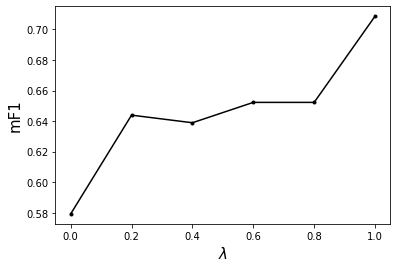

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(lambs, mF1s,'k.-')
plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('mF1', fontsize=15)
plt.show()

In [20]:
categMetric(discriminator, index=discriminator.dataset.index_test, lamb=1.0)

KeyboardInterrupt: 

* which features contribute to the prob?
* is similarity really necessary? no negative cross-simi pairs will contribute

    * simi -> rule based
    * one-hot -> learning

In [66]:
import glob
import random
def getMaterial(layer):
    l = glob.glob('material/%s*.png' % layer)
    return random.choice(l)

from tools.image_process import stack_svgs
stack_svgs([getMaterial(layer) for layer in layers])

from IPython.display import SVG, display
from IPython.display import HTML
def show_svg():
    # display(HTML("<style>.container { width:100% !important; }</style>"))
    # style = "<style>svg{width:50% !important;height:50% !important;}</style>"
    # display(HTML(style))
    display(SVG('stack.svg'))
show_svg()

Canvas size: (395, 501)
File: material/A2222_(8).png
File: material/A3211_(3).png


In [32]:
## Check feature and vector are consistent

In [31]:
layers, sentence = dataset.getOneLayerSent(txt_name='text/1.txt', img_name='images/6.svg')
print(layers)
print(dataset.img_encoder.layer2keyword(layers))
print(sentence)
list(filter(lambda x: x[1]!=0, zip(dataset.joint_encoder.features_, dataset.joint_encoder.encode(layers, sentence))))

['A2112', 'A311']
['indoor.a.01', 'object.n.01', 'appliance.n.02', 'interaction.n.01', 'occupation.n.01']
A man looks at his chart with his back.



[('_S_object.n.01_back.n.01_', 1.845826690498331),
 ('_S_object.n.01_chart.n.01_', 1.6916760106710724),
 ('_S_object.n.01_man.n.01_', 1.845826690498331),
 ('_S_appliance.n.02_back.n.01_', 1.1526795099383855),
 ('_S_appliance.n.02_chart.n.01_', 1.072636802264849),
 ('_S_appliance.n.02_man.n.01_', 1.2396908869280152),
 ('_P_interaction.n.01_back.n.01_', 1.1526795099383855),
 ('_P_interaction.n.01_chart.n.01_', 1.4403615823901665),
 ('_P_interaction.n.01_man.n.01_', 1.1526795099383855),
 ('_P_occupation.n.01_back.n.01_', 1.1526795099383855),
 ('_P_occupation.n.01_chart.n.01_', 1.4403615823901665),
 ('_P_occupation.n.01_man.n.01_', 1.1526795099383855)]

## XGB

In [9]:
import xgboost as xgb

In [10]:
w = np.array([1 if y_ == 1 else 0.3 for y_ in y[:ind_test]])
dtrain = xgb.DMatrix(X[:ind_test], label=y[:ind_test], weight=w, feature_names=dataset.features_)

dtest = xgb.DMatrix(X[ind_test:],
                    label=y[ind_test:],
                    feature_names=dataset.features_,)

In [11]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [12]:
num_round = 20
bst = xgb.train(param, dtrain, num_round,
                evallist, early_stopping_rounds=3)
# ypred = bst.predict(dtest)

[0]	eval-auc:0.5	train-auc:0.601725
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 3 rounds.
[1]	eval-auc:0.565	train-auc:0.672814
[2]	eval-auc:0.6025	train-auc:0.708209
[3]	eval-auc:0.615	train-auc:0.734347
[4]	eval-auc:0.6325	train-auc:0.759816
[5]	eval-auc:0.6625	train-auc:0.770152
[6]	eval-auc:0.6675	train-auc:0.774836
[7]	eval-auc:0.61	train-auc:0.783946
[8]	eval-auc:0.665	train-auc:0.801643
[9]	eval-auc:0.635	train-auc:0.809823
[10]	eval-auc:0.665	train-auc:0.814173
[11]	eval-auc:0.6625	train-auc:0.819416
[12]	eval-auc:0.6625	train-auc:0.827112
[13]	eval-auc:0.645	train-auc:0.829045
[14]	eval-auc:0.635	train-auc:0.82793
[15]	eval-auc:0.635	train-auc:0.831797
[16]	eval-auc:0.6325	train-auc:0.834994
[17]	eval-auc:0.6575	train-auc:0.835849
[18]	eval-auc:0.6575	train-auc:0.840534
[19]	eval-auc:0.6425	train-auc:0.839307


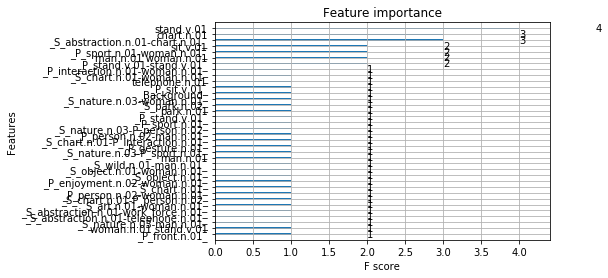

In [13]:
xgb.plot_importance(bst)

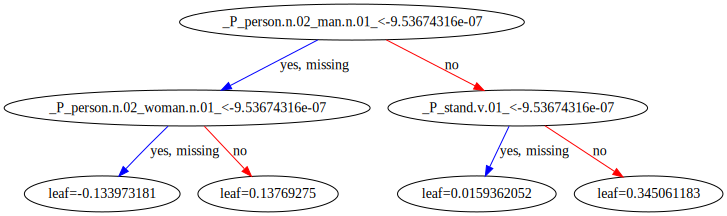

In [30]:
xgb.to_graphviz(bst, num_trees=19)